In [ ]:
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter, XMLConverter, HTMLConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage
from io import BytesIO
import configparser

class PdfExtractor2:
    def __init__(self):
            self.config = configparser.ConfigParser()
            self.config.read('retail.ini')

    def main(self):
        print('main xml')
        xml = self.convert_pdf('catalogue_internet_qc_2018-04-28_v2018-04-13.pdf', 'xml')
        print(xml)
        
    
    def convert_pdf(self, path, format='text', codec='utf-8', password=''):
        rsrcmgr = PDFResourceManager()
        retstr = BytesIO()
        laparams = LAParams()
        if format == 'text':
            device = TextConverter(rsrcmgr, retstr, codec=codec, laparams=laparams)
        elif format == 'html':
            device = HTMLConverter(rsrcmgr, retstr, codec=codec, laparams=laparams)
        elif format == 'xml':
            device = XMLConverter(rsrcmgr, retstr, codec=codec, laparams=laparams)
        else:
            raise ValueError('provide format, either text, html or xml!')
        fp = open(path, 'rb')
        interpreter = PDFPageInterpreter(rsrcmgr, device)
        maxpages = 0
        caching = True
        pagenos=set()
        for i, page in enumerate(PDFPage.get_pages(fp, pagenos, maxpages=maxpages, \
                                                   password=password,caching=caching, check_extractable=True)):
            if i ==20:
                interpreter.process_page(page)
                text = retstr.getvalue().decode()
                
        fp.close()
        device.close()
        retstr.close()
        return text

In [ ]:
pdf = PdfExtractor2()
pdf.main()

## Assessing the content

In [4]:
from pdfminer.pdfparser import PDFParser
from pdfminer.pdfdocument import PDFDocument
from pdfminer.pdfpage import PDFPage
from pdfminer.pdfpage import PDFTextExtractionNotAllowed
from pdfminer.pdfinterp import PDFResourceManager
from pdfminer.pdfinterp import PDFPageInterpreter
from pdfminer.layout import LAParams
from pdfminer.converter import PDFPageAggregator


def extract_layout_by_page(pdf_path):
    """
    Extracts LTPage objects from a pdf file.
    
    slightly modified from
    https://euske.github.io/pdfminer/programming.html
    """
    laparams = LAParams()

    fp = open(pdf_path, 'rb')
    parser = PDFParser(fp)
    document = PDFDocument(parser)

    if not document.is_extractable:
        raise PDFTextExtractionNotAllowed

    rsrcmgr = PDFResourceManager()
    device = PDFPageAggregator(rsrcmgr, laparams=laparams)
    interpreter = PDFPageInterpreter(rsrcmgr, device)

    layouts = []
    for page in PDFPage.create_pages(document):
        interpreter.process_page(page)
        layouts.append(device.get_result())

    return layouts

example_file = "catalogue_internet_qc_2018-04-28_v2018-04-13.pdf"
page_layouts = extract_layout_by_page(example_file)
nb_pages = len(page_layouts)

objects_on_page = set(type(o) for o in page_layouts[3])
objects_on_page

{pdfminer.layout.LTCurve,
 pdfminer.layout.LTFigure,
 pdfminer.layout.LTRect,
 pdfminer.layout.LTTextBoxHorizontal}

In [5]:
import pdfminer

TEXT_ELEMENTS = [
    pdfminer.layout.LTTextBox,
    pdfminer.layout.LTTextBoxHorizontal,
    pdfminer.layout.LTTextLine,
    pdfminer.layout.LTTextLineHorizontal
]

def flatten(lst):
    """Flattens a list of lists"""
    return [subelem for elem in lst for subelem in elem]


def extract_characters(element):
    """
    Recursively extracts individual characters from 
    text elements. 
    """
    if isinstance(element, pdfminer.layout.LTChar):
        return [element]

    if any(isinstance(element, i) for i in TEXT_ELEMENTS):
        return flatten([extract_characters(e) for e in element])

    if isinstance(element, list):
        return flatten([extract_characters(l) for l in element])

    return []

In [12]:
current_page = page_layouts[4]

texts = []
rects = []

# seperate text and rectangle elements
for e in current_page:
    if isinstance(e, pdfminer.layout.LTTextBoxHorizontal):
        texts.append(e)
    elif isinstance(e, pdfminer.layout.LTRect):
        rects.append(e)

# sort them into 
characters = extract_characters(texts)

In [19]:
import matplotlib.pyplot as plt
from matplotlib import patches
%matplotlib inline

   
def draw_rect_bbox(x0,y0,x1,y1, ax, color):
    """
    Draws an unfilled rectable onto ax.
    """
    ax.add_patch(patches.Rectangle((x0, y0), x1 - x0, y1 - y0, fill=False, color=color))
    
def draw_rect(rect, ax, color="black"):
    draw_rect_bbox(rect.x0,rect.y0,rect.x1,rect.y1, ax, color)

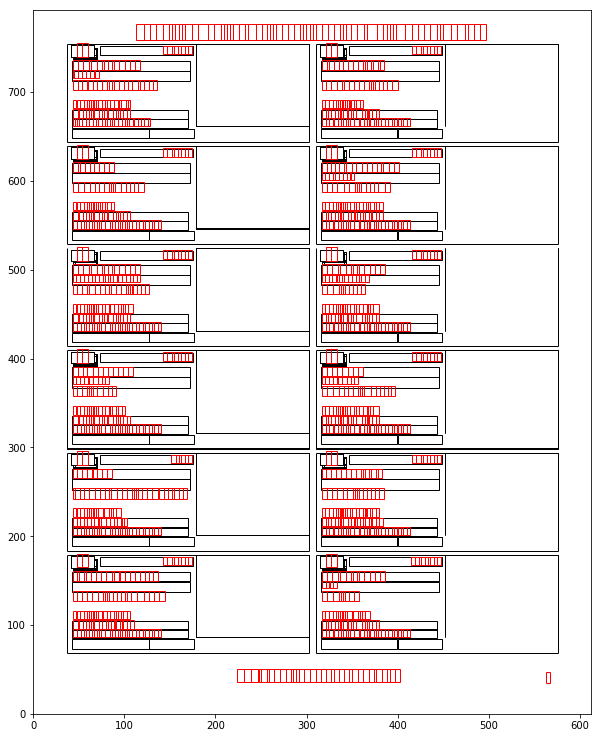

In [22]:
xmin, ymin, xmax, ymax = current_page.bbox
size = 10

fig, ax = plt.subplots(figsize = (size, size * (ymax/xmax)))

for rect in rects:
    draw_rect(rect, ax)
    #print(rect.x0)
    
    
for c in characters:
    draw_rect(c, ax, "red")
     

plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.show()

In [24]:
def width(rect):
    x0, y0, x1, y1 = rect.bbox
    return min(x1 - x0, y1 - y0)

def area(rect):
    x0, y0, x1, y1 = rect.bbox
    return (x1 - x0) * (y1 - y0)


def cast_as_line(rect):
    """
    Replaces a retangle with a line based on its longest dimension.
    """
    x0, y0, x1, y1 = rect.bbox

    if x1 - x0 > y1 - y0:
        return (x0, y0, x1, y0, "H")
    else:
        return (x0, y0, x0, y1, "V")
    
lines = [cast_as_line(r) for r in rects
         if width(r) < 2 and
         area(r) > 1]

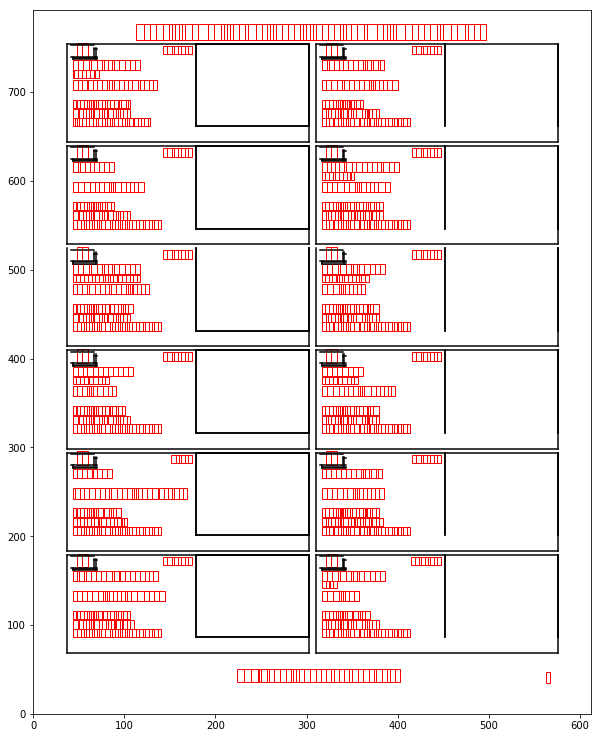

In [27]:
xmin, ymin, xmax, ymax = current_page.bbox
size = 10

fig, ax = plt.subplots(figsize = (size, size * (ymax/xmax)))

for l in lines:
    x0,y0,x1,y1,_ = l
    plt.plot([x0, x1], [y0, y1], 'k-')
  
for c in characters:
    draw_rect(c, ax, "red")

plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.show()

In [35]:
def does_it_intersect(x, xmin, xmax):
    return (x <= xmax and x >= xmin)

def find_bounding_rectangle(x, y, lines):
    """
    Given a collection of lines, and a point, try to find the rectangle 
    made from the lines that bounds the point. If the point is not 
    bounded, return None.
    """
    
    v_intersects = [l for l in lines
                    if l[4] == "V"
                    and does_it_intersect(y, l[1], l[3])]

    h_intersects = [l for l in lines
                    if l[4] == "H"
                    and does_it_intersect(x, l[0], l[2])]

    if len(v_intersects) < 2 or len(h_intersects) < 2:
        return None

    v_left = [v[0] for v in v_intersects
              if v[0] < x]

    v_right = [v[0] for v in v_intersects
               if v[0] > x]

    if len(v_left) == 0 or len(v_right) == 0:
        return None

    x0, x1 = max(v_left), min(v_right)

    h_down = [h[1] for h in h_intersects
              if h[1] < y]

    h_up = [h[1] for h in h_intersects
            if h[1] > y]

    if len(h_down) == 0 or len(h_up) == 0:
        return None

    y0, y1 = max(h_down), min(h_up)

    return (x0, y0, x1, y1)

In [36]:
from collections import defaultdict
import math

box_char_dict = {}

for c in characters:
    # choose the bounding box that occurs the majority of times for each of these:
    bboxes = defaultdict(int)
    l_x, l_y = c.bbox[0], c.bbox[1]
    bbox_l = find_bounding_rectangle(l_x, l_y, lines)
    bboxes[bbox_l] += 1

    c_x, c_y = math.floor((c.bbox[0] + c.bbox[2]) / 2), math.floor((c.bbox[1] + c.bbox[3]) / 2)
    bbox_c = find_bounding_rectangle(c_x, c_y, lines)
    bboxes[bbox_c] += 1

    u_x, u_y = c.bbox[2], c.bbox[3]
    bbox_u = find_bounding_rectangle(u_x, u_y, lines)
    bboxes[bbox_u] += 1

    # if all values are in different boxes, default to character center.
    # otherwise choose the majority.
    if max(bboxes.values()) == 1:
        bbox = bbox_c
    else:
        bbox = max(bboxes.items(), key=lambda x: x[1])[0]

    if bbox is None:
        continue

    if bbox in box_char_dict.keys():
        box_char_dict[bbox].append(c)
        continue

    box_char_dict[bbox] = [c]

In [39]:
xmin, ymin, xmax, ymax = current_page.bbox

for x in range(int(xmin), int(xmax), 10):
    for y in range(int(ymin), int(ymax), 10):
        bbox = find_bounding_rectangle(x, y, lines)

        if bbox is None:
            continue

        if bbox in box_char_dict.keys():
            continue

        box_char_dict[bbox] = []

In [40]:
def chars_to_string(chars):
    """
    Converts a collection of characters into a string, by ordering them left to right, 
    then top to bottom.
    """
    if not chars:
        return ""
    rows = sorted(list(set(c.bbox[1] for c in chars)), reverse=True)
    text = ""
    for row in rows:
        sorted_row = sorted([c for c in chars if c.bbox[1] == row], key=lambda c: c.bbox[0])
        text += "".join(c.get_text() for c in sorted_row)
    return text


def boxes_to_table(box_record_dict):
    """
    Converts a dictionary of cell:characters mapping into a python list
    of lists of strings. Tries to split cells into rows, then for each row 
    breaks it down into columns.
    """
    boxes = box_record_dict.keys()
    rows = sorted(list(set(b[1] for b in boxes)), reverse=True)
    table = []
    for row in rows:
        sorted_row = sorted([b for b in boxes if b[1] == row], key=lambda b: b[0])
        table.append([chars_to_string(box_record_dict[b]) for b in sorted_row])
    return table

In [41]:
boxes_to_table(box_char_dict)

[[''],
 [''],
 ['37', '', '38', ''],
 [''],
 ['CAMIONCENDIESPART1994      Diesel  Arrécupér',
  'N 10 ROUESAN   RA40M-316479 777  mi.utomatiqueable (pour pièces)',
  'II',
  '',
  '',
  '',
  '',
  'VQ-94609',
  'NIVELEJOHN D1999      Diesel  AVéhicule',
  'USE  4 X 4EERE   772CH  hresutomatique remisé le  2018-03-31',
  '',
  '',
  '',
  'VQ-99707',
  ''],
 [''],
 ['39', '40'],
 [''],
 ['NIVELEKOMAT2000      Diesel  AVéhicule',
  'USESU   GD650A  hresutomatique remisé le  2018-01-30',
  '',
  '',
  '',
  '',
  'VQ-00786',
  'PELLE SUR ROUDAEWO2004      Diesel  HVéhicule',
  'HYDRAULIQUEESO   S180WV14 603  hresydrostatique remisé le  2018-03-31',
  '',
  '',
  '',
  'VQ-04751',
  ''],
 [''],
 [''],
 ['41', '', '42', ''],
 [''],
 ['CAMIOÉPANDEUFREIGH2001      Diesel  AVéhicule',
  'N 10 ROUESR/AILE/GRATTETLINER   FL80196 193  kmutomatique remisé le  2017-11-30',
  '',
  '',
  '',
  '',
  'VQ-01688',
  'CAMIOBALAI À SGMC   2008      Diesel  AVéhicule',
  'N 6 ROUESUCCIONT750052 152  kmut